In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths to your dataset
train_data_dir = 'datasets2/train'
test_data_dir = 'datasets2/test'




In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np

# Define image dimensions
img_width, img_height = 150,150

# Create the ImageDataGenerator for grayscale images
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directory for training and testing data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)
# Extract data from the generators
def extract_data(generator):
    X, y = [], []
    for _ in range(len(generator)):
        images, labels = next(generator)
        X.extend(images)
        y.extend(labels)
    return np.array(X), np.array(y)

# Convert training and validation data to numpy arrays
X_train, y_train = extract_data(train_generator)
X_test, y_test = extract_data(validation_generator)
# Verify the shapes of the extracted data
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')



Found 864 images belonging to 10 classes.
Found 229 images belonging to 10 classes.
X_train shape: (864, 150, 150, 3)
y_train shape: (864, 10)
X_test shape: (229, 150, 150, 3)
y_test shape: (229, 10)


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D

# Define the image dimensions
img_width, img_height = 150, 150

# Paths to your dataset directories
train_data_dir = 'datasets2/train'
test_data_dir = 'datasets2/test'

# Image data generators for training and testing sets
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Training and testing data generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)

# Load the VGG16 model pre-trained on ImageNet, without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the base model layers
base_model.trainable = False

# Define the custom top layers
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(train_generator.num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=4
)

# Optionally, unfreeze some layers of the base model and fine-tune the model
base_model.trainable = True
fine_tune_at = 15  # Layer from which we want to fine-tune

# Freeze all layers before the fine-tune layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Re-compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Fine-tune the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=4  # You can increase the number of epochs for fine-tuning
)

# Save the model
model.save("fine_tuned_odia_digit_recognition_model.h5")


Found 864 images belonging to 10 classes.
Found 229 images belonging to 10 classes.
Epoch 1/4


/Users/shreekta/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.2359 - loss: 2.1830 - precision: 0.8214 - recall: 0.0216 - val_accuracy: 0.7902 - val_loss: 1.2991 - val_precision: 1.0000 - val_recall: 0.1116
Epoch 2/4


2024-07-04 11:30:33.534143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/shreekta/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8000 - val_loss: 1.3763 - val_precision: 1.0000 - val_recall: 0.2000
Epoch 3/4


2024-07-04 11:30:33.809555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.7170 - loss: 1.2837 - precision: 0.9724 - recall: 0.1687 - val_accuracy: 0.9911 - val_loss: 0.6864 - val_precision: 1.0000 - val_recall: 0.4821
Epoch 4/4


2024-07-04 11:31:30.927195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.9076 - val_precision: 1.0000 - val_recall: 0.2000


2024-07-04 11:31:31.202164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 1/4
27/27 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.9226 - loss: 0.5711 - precision_1: 0.9959 - recall_1: 0.6406 - val_accuracy: 1.0000 - val_loss: 0.1645 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 2/4


2024-07-04 11:32:42.388631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.2596 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 3/4


2024-07-04 11:32:42.713210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


27/27 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.9823 - loss: 0.1897 - precision_1: 0.9908 - recall_1: 0.9589 - val_accuracy: 1.0000 - val_loss: 0.0603 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 4/4


2024-07-04 11:33:52.812718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0566 - val_precision_1: 1.0000 - val_recall_1: 1.0000


2024-07-04 11:33:53.106502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [28]:
model.save('')


In [19]:
from tensorflow.keras.models import load_model

model=load_model("fine_tuned_odia_digit_recognition_model.h5")

Processing image: output/frame_1.png
Original image shape: (720, 1280)
Cropped image shape: (21, 21)
Resized image shape: (150, 150)


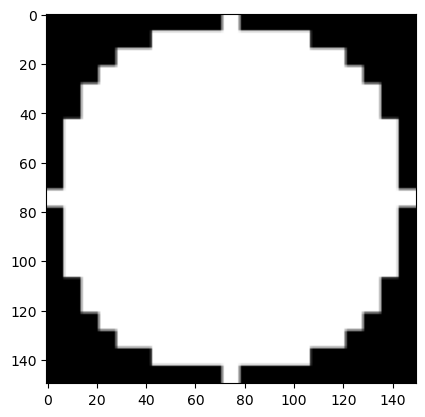

Image shape after adding batch dimension: (1, 150, 150, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
Prediction: [[0.00135699 0.00896808 0.00561107 0.14391014 0.00181552 0.0060096
  0.00084232 0.00128921 0.78031623 0.04988085]]
Predicted class index: [8]
Class labels: ['୦', '୧', '୨', '୩', '୪', '୫', '୬', '୭', '୮', '୯']
Predicted label: ୮
Odia digit:
The predicted class is: ୮


In [20]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from PIL import Image, ImageDraw, ImageFont
import blur_erase2

# Preprocess and predict function
def preprocess_and_predict_image(model, img_path, target_size):
    print(f"Processing image: {img_path}")

    # Read the image using OpenCV in grayscale mode
    test_image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    print(f"Original image shape: {test_image.shape}")

    # Find the bounding box of the white part
    coords = cv2.findNonZero(test_image)  # Find all non-zero points (white)
    x, y, w, h = cv2.boundingRect(coords)  # Find the bounding box of the non-zero points
    cropped_image = test_image[y:y+h, x:x+w]  # Crop the image to the bounding box
    print(f"Cropped image shape: {cropped_image.shape}")

    # Resize the cropped image to the target size
    img_resized = cv2.resize(cropped_image, target_size, interpolation=cv2.INTER_AREA)
    print(f"Resized image shape: {img_resized.shape}")
    
    # Convert the grayscale image to RGB by duplicating the single channel
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
    
    # Display the preprocessed image (optional)
    plt.imshow(img_rgb, cmap='gray')
    plt.show()
    
    # Normalize the image
    img_rgb = img_rgb / 255.0
    
    # Add the batch dimension
    img_rgb = np.expand_dims(img_rgb, axis=0)
    print(f"Image shape after adding batch dimension: {img_rgb.shape}")
    
    # Predict the class
    prediction = model.predict(img_rgb)
    print(f"Prediction: {prediction}")
    predicted_class = np.argmax(prediction, axis=1)
    print(f"Predicted class index: {predicted_class}")
    
    return predicted_class

# Define the target size (should be the same as the input size of the model)
img_width, img_height = 150, 150 # Update these values as needed
target_size = (img_width, img_height)

# Path to the user-provided image
img_path = "output/frame_99.png"

# Load the trained model (if not already loaded)
model = load_model("fine_tuned_odia_digit_recognition_model.h5")  # Update the path to your model

# Predict the class
predicted_class = preprocess_and_predict_image(model, img_path, target_size)

# Assuming train_generator is already defined and trained
# Map the predicted class index to the actual class label
class_labels = list(train_generator.class_indices.keys())
print(f"Class labels: {class_labels}")

predicted_label = class_labels[predicted_class[0]]
print(f"Predicted label: {predicted_label}")

# Display the predicted label in Odia digit using Anek Odia font
odia_digit = chr(int(predicted_label))
print(f"Odia digit: {odia_digit}")

# Load the Anek Odia font (update the path to the font file)
font_path = "Anek_Odia/AnekOdia-VariableFont_wdth,wght.ttf"
font_size = 100  # Adjust the font size as needed
font = ImageFont.truetype(font_path, font_size)

# Create an image with the Odia digit
img = Image.new('RGB', (200, 200), color='white')
draw = ImageDraw.Draw(img)
draw.text((50, 50), odia_digit, font=font, fill='black')

# Display the image with the Odia digit
img.show()

print(f"The predicted class is: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Confusion Matrix:
[[45  0  0  0  0  0  0  0  0  0]
 [ 0 43  0  0  0  0  0  0  0  0]
 [ 0  0 34  0  0  0  0  0  0  0]
 [ 0  0  0 40  0  0  0  0  0  0]
 [ 0  0  0  0 36  0  0  0  0  0]
 [ 0  0  0  0  0 39  0  0  0  0]
 [ 0  0  0  0  0  0 27  0  0  0]
 [ 0  0  0  0  0  0  0 49  0  0]
 [ 0  0  0  0  0  0  0  0 34  0]
 [ 0  0  0  0  0  0  0  0  0 35]]


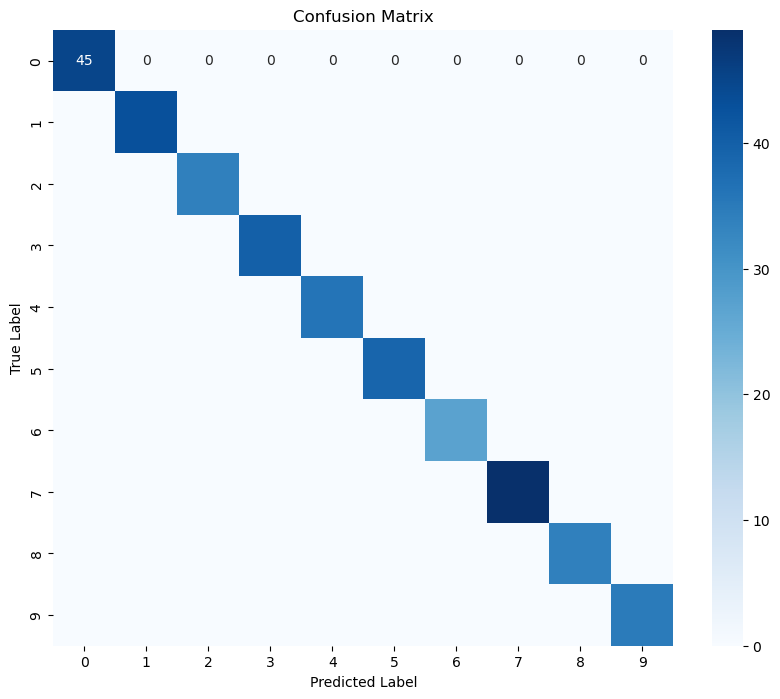

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Collect true labels and predicted labels for test images
true_labels = []
predicted_labels = []

# Assuming test_generator is already defined and provides batches of test images
for i in range(len(validation_generator)):
    x_batch, y_batch = validation_generator[i]
    y_true = np.argmax(y_batch, axis=1)
    y_pred = np.argmax(model.predict(x_batch), axis=1)
    true_labels.extend(y_true)
    predicted_labels.extend(y_pred)

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [12]:
import pickle

# Specify the filename
filename = 'digit.pkl'

# Open a file in binary mode and write the model to it
with open(filename, 'wb') as file:
    pickle.dump(model,file)